Carregando modelo CNN+TCN e scaler...
Modelo CNN+TCN carregado de: processed_data/best_model_cnn_tcn.keras
Scaler CNN+TCN carregado de: processed_data/scaler_model_cnn_tcn.joblib

Carregando modelo LSTM e scaler...
Modelo LSTM carregado de: processed_data/best_model_cnn_lstm.keras
Scaler LSTM carregado de: processed_data/scaler_model_cnn_lstm.joblib

Carregando dados de teste X (escalonados) de: processed_data/X_test_scaled.npy
Shape de X_test_scaled carregado: (2202, 90, 2)
Carregando labels de teste Y de: processed_data/y_test_labels.npy
Shape de y_test carregado: (2202,)

Modelo CNN+TCN espera formato de entrada: (None, 90, 2)
Modelo LSTM espera formato de entrada: (None, 90, 2)

--- Fazendo predições com os modelos individuais ---
Predizendo com CNN+TCN...
Predizendo com LSTM...

--- Avaliação do Modelo: CNN+TCN Individual ---
  Acurácia: 0.8188
  Relatório de Classificação:
              precision    recall  f1-score   support

Não Fadigado     0.8519    0.8599    0.8559      1378

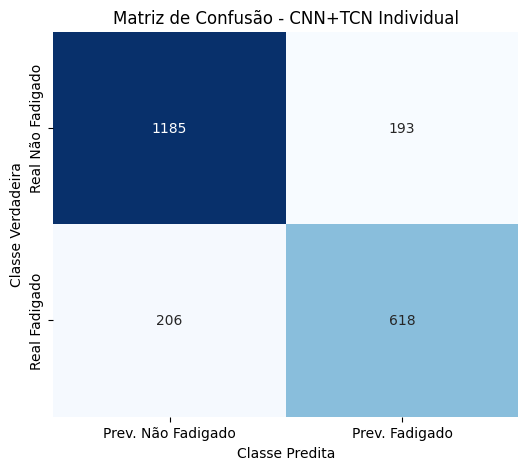


--- Avaliação do Modelo: LSTM Individual ---
  Acurácia: 0.8302
  Relatório de Classificação:
              precision    recall  f1-score   support

Não Fadigado     0.8697    0.8570    0.8633      1378
    Fadigado     0.7666    0.7852    0.7758       824

    accuracy                         0.8302      2202
   macro avg     0.8181    0.8211    0.8195      2202
weighted avg     0.8311    0.8302    0.8306      2202

  AUC: 0.9028

  Matriz de Confusão:
[[1181  197]
 [ 177  647]]


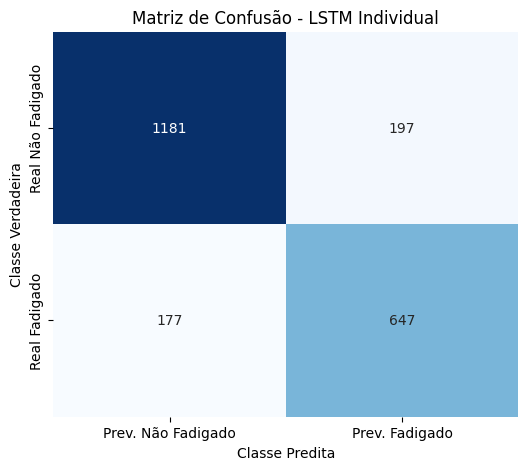


--- Testando o Modelo Ensemble por Votação ---

--- Avaliação do Modelo: Ensemble (Votação Hard) ---
  Acurácia: 0.8356
  Relatório de Classificação:
              precision    recall  f1-score   support

Não Fadigado     0.8387    0.9129    0.8742      1378
    Fadigado     0.8291    0.7063    0.7628       824

    accuracy                         0.8356      2202
   macro avg     0.8339    0.8096    0.8185      2202
weighted avg     0.8351    0.8356    0.8325      2202

  Não foi possível calcular AUC (probabilidades ausentes ou apenas uma classe nos rótulos verdadeiros).

  Matriz de Confusão:
[[1258  120]
 [ 242  582]]


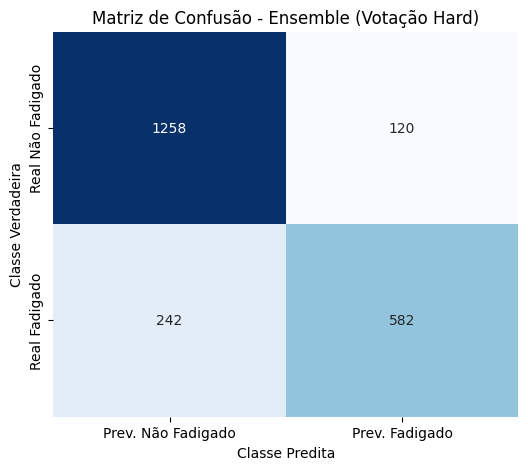


--- Testando o Modelo Ensemble por Média de Probabilidades (Votação Soft) ---

--- Avaliação do Modelo: Ensemble (Votação Soft - Média de Probabilidades) ---
  Acurácia: 0.8361
  Relatório de Classificação:
              precision    recall  f1-score   support

Não Fadigado     0.8709    0.8665    0.8687      1378
    Fadigado     0.7786    0.7852    0.7819       824

    accuracy                         0.8361      2202
   macro avg     0.8247    0.8258    0.8253      2202
weighted avg     0.8364    0.8361    0.8362      2202

  AUC: 0.9066

  Matriz de Confusão:
[[1194  184]
 [ 177  647]]


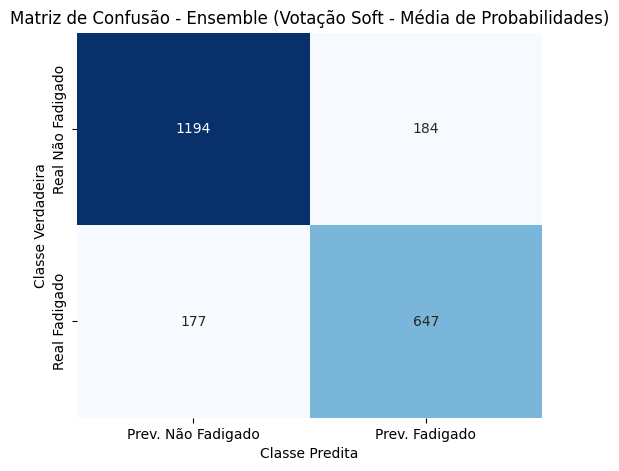


Teste dos modelos e do ensemble concluído.


In [2]:
import numpy as np
import pandas as pd # Importado para melhor visualização do classification_report se necessário
import tensorflow as tf
from tensorflow import keras
from joblib import load
import os
import matplotlib.pyplot as plt
import seaborn as sns # Importado para visualização da matriz de confusão

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix

# --- Configurações ---
DATA_DIR = 'processed_data'

# Nomes dos arquivos de dados de teste
TEST_DATA_FILE_X = 'X_test_scaled.npy'
TEST_DATA_FILE_Y = 'y_test_labels.npy'

# Caminhos completos para os modelos e scalers
MODEL_CNN_TCN_PATH = os.path.join(DATA_DIR, 'best_model_cnn_tcn.keras')
SCALER_CNN_TCN_PATH = os.path.join(DATA_DIR, 'scaler_model_cnn_tcn.joblib')

MODEL_LSTM_PATH = os.path.join(DATA_DIR, 'best_model_cnn_lstm.keras')
SCALER_LSTM_PATH = os.path.join(DATA_DIR, 'scaler_model_cnn_lstm.joblib')

# --- Carregar Modelos e Scalers ---
model_cnn_tcn = None
scaler_cnn_tcn = None
model_lstm = None
scaler_lstm = None

try:
    print("Carregando modelo CNN+TCN e scaler...")
    model_cnn_tcn = keras.models.load_model(MODEL_CNN_TCN_PATH)
    scaler_cnn_tcn = load(SCALER_CNN_TCN_PATH)
    print(f"Modelo CNN+TCN carregado de: {MODEL_CNN_TCN_PATH}")
    print(f"Scaler CNN+TCN carregado de: {SCALER_CNN_TCN_PATH}")

    print("\nCarregando modelo LSTM e scaler...")
    model_lstm = keras.models.load_model(MODEL_LSTM_PATH)
    scaler_lstm = load(SCALER_LSTM_PATH)
    print(f"Modelo LSTM carregado de: {MODEL_LSTM_PATH}")
    print(f"Scaler LSTM carregado de: {SCALER_LSTM_PATH}")

except Exception as e:
    print(f"Erro ao carregar modelos ou scalers: {e}")
    print("Verifique se os arquivos existem nos caminhos especificados e se estão corretos.")
    exit()

# --- Carregar Dados de Teste ---
X_test_scaled = None
y_test = None
try:
    full_X_test_path = os.path.join(DATA_DIR, TEST_DATA_FILE_X)
    print(f"\nCarregando dados de teste X (escalonados) de: {full_X_test_path}")
    X_test_scaled = np.load(full_X_test_path)
    print(f"Shape de X_test_scaled carregado: {X_test_scaled.shape}")

    full_y_test_path = os.path.join(DATA_DIR, TEST_DATA_FILE_Y)
    print(f"Carregando labels de teste Y de: {full_y_test_path}")
    y_test = np.load(full_y_test_path)
    print(f"Shape de y_test carregado: {y_test.shape}")

    if y_test.ndim > 1 and y_test.shape[1] == 1:
        y_test = y_test.flatten()

except Exception as e:
    print(f"Erro ao carregar dados de teste: {e}")
    print("Certifique-se de que os arquivos de dados de teste (X_test_scaled.npy, y_test_labels.npy) existem e estão corretos no diretório especificado.")
    exit()

# --- Verificar as Dimensões dos Modelos e Dados de Teste ---
timesteps_tcn, features_tcn = model_cnn_tcn.input_shape[1:]
timesteps_lstm, features_lstm = model_lstm.input_shape[1:]

print(f"\nModelo CNN+TCN espera formato de entrada: (None, {timesteps_tcn}, {features_tcn})")
print(f"Modelo LSTM espera formato de entrada: (None, {timesteps_lstm}, {features_lstm})")

if X_test_scaled.shape[1] != timesteps_tcn or X_test_scaled.shape[2] != features_tcn:
    print(f"\nAVISO: X_test_scaled ({X_test_scaled.shape}) não corresponde à entrada esperada pelo CNN+TCN ({timesteps_tcn}, {features_tcn}).")
    print("Verifique se seus dados de teste foram gerados com os mesmos timesteps e features que os modelos esperam.")

if X_test_scaled.shape[1] != timesteps_lstm or X_test_scaled.shape[2] != features_lstm:
    print(f"\nAVISO: X_test_scaled ({X_test_scaled.shape}) não corresponde à entrada esperada pelo LSTM ({timesteps_lstm}, {features_lstm}).")
    print("Verifique se seus dados de teste foram gerados com os mesmos timesteps e features que os modelos esperam.")

if scaler_cnn_tcn.n_features_in_ != features_tcn:
    print(f"\nERRO: Scaler CNN+TCN esperava {scaler_cnn_tcn.n_features_in_} features, mas o modelo espera {features_tcn}.")
    print("Isso indica uma inconsistência entre o scaler e o modelo.")
    exit()
if scaler_lstm.n_features_in_ != features_lstm:
    print(f"\nERRO: Scaler LSTM esperava {scaler_lstm.n_features_in_} features, mas o modelo espera {features_lstm}.")
    print("Isso indica uma inconsistência entre o scaler e o modelo.")
    exit()

# --- Função de Avaliação Aprimorada (com Matriz de Confusão) ---
def evaluate_model_performance(y_true, y_pred_class, y_pred_proba, model_name):
    """
    Avalia e imprime a performance de um conjunto de predições, incluindo AUC e Matriz de Confusão.
    Todas as métricas são formatadas para 4 casas decimais.
    """
    print(f"\n--- Avaliação do Modelo: {model_name} ---")

    # Acurácia
    accuracy = accuracy_score(y_true, y_pred_class)
    print(f"  Acurácia: {accuracy:.4f}")

    # Relatório de Classificação
    print("  Relatório de Classificação:")
    print(classification_report(y_true, y_pred_class, target_names=["Não Fadigado", "Fadigado"], digits=4))

    # AUC
    if y_pred_proba is not None and len(np.unique(y_true)) > 1:
        try:
            auc_score = roc_auc_score(y_true, y_pred_proba)
            print(f"  AUC: {auc_score:.4f}")
            # Plot da Curva ROC (mantido opcional e comentado)
            # fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
            # plt.figure(figsize=(6, 4))
            # plt.plot(fpr, tpr, label=f'Curva ROC (área = {auc_score:.4f})')
            # plt.plot([0, 1], [0, 1], 'k--')
            # plt.xlim([0.0, 1.0])
            # plt.ylim([0.0, 1.05])
            # plt.xlabel('Taxa de Falsos Positivos (FPR)')
            # plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
            # plt.title(f'Característica de Operação do Receptor - {model_name}')
            # plt.legend(loc="lower right")
            # plt.grid(True)
            # plt.show()
        except ValueError as e:
            print(f"  Não foi possível calcular AUC para {model_name}: {e}")
    else:
        print("  Não foi possível calcular AUC (probabilidades ausentes ou apenas uma classe nos rótulos verdadeiros).")

    # Matriz de Confusão
    cm = confusion_matrix(y_true, y_pred_class)
    print("\n  Matriz de Confusão:")
    print(cm)

    # Visualização da Matriz de Confusão
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=["Prev. Não Fadigado", "Prev. Fadigado"],
                yticklabels=["Real Não Fadigado", "Real Fadigado"])
    plt.xlabel('Classe Predita')
    plt.ylabel('Classe Verdadeira')
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.show()


# --- Predições dos Modelos Individuais ---
print("\n--- Fazendo predições com os modelos individuais ---")

print("Predizendo com CNN+TCN...")
y_pred_proba_tcn = model_cnn_tcn.predict(X_test_scaled, verbose=0)
if y_pred_proba_tcn.shape[-1] == 1:
    y_pred_proba_tcn = y_pred_proba_tcn.flatten()
y_pred_class_tcn = (y_pred_proba_tcn > 0.5).astype(int)

print("Predizendo com LSTM...")
y_pred_proba_lstm = model_lstm.predict(X_test_scaled, verbose=0)
if y_pred_proba_lstm.shape[-1] == 1:
    y_pred_proba_lstm = y_pred_proba_lstm.flatten()

# ATENÇÃO: Lógica de Inversão para o LSTM (MANTIDA DO CÓDIGO ANTERIOR)
# Se necessário, descomente e ajuste esta linha para que y_pred_proba_lstm
# represente a probabilidade da CLASSE POSITIVA (Fadigado, se 1 é Fadigado).
# y_pred_proba_lstm = 1 - y_pred_proba_lstm # Descomente APENAS se necessário

y_pred_class_lstm = (y_pred_proba_lstm > 0.5).astype(int)

# --- Avaliação dos Modelos Individuais ---
evaluate_model_performance(y_test, y_pred_class_tcn, y_pred_proba_tcn, "CNN+TCN Individual")
evaluate_model_performance(y_test, y_pred_class_lstm, y_pred_proba_lstm, "LSTM Individual")


# --- Testando o Ensemble por Votação ---
print("\n--- Testando o Modelo Ensemble por Votação ---")

# Votação Hard (Majoritária)
predictions_matrix = np.array([y_pred_class_tcn, y_pred_class_lstm])
predictions_matrix_transposed = predictions_matrix.T
ensemble_votes = np.mean(predictions_matrix_transposed, axis=1)
y_pred_ensemble_voting_hard_class = (ensemble_votes > 0.5).astype(int)

evaluate_model_performance(y_test, y_pred_ensemble_voting_hard_class, None, "Ensemble (Votação Hard)")


# --- Votação Soft (Média de Probabilidades) ---
print("\n--- Testando o Modelo Ensemble por Média de Probabilidades (Votação Soft) ---")

avg_ensemble_proba = (y_pred_proba_tcn + y_pred_proba_lstm) / 2.0
y_pred_ensemble_soft_class = (avg_ensemble_proba > 0.5).astype(int)

evaluate_model_performance(y_test, y_pred_ensemble_soft_class, avg_ensemble_proba, "Ensemble (Votação Soft - Média de Probabilidades)")

print("\nTeste dos modelos e do ensemble concluído.")